# Single-site traces

author: laquitainesteeve@gmail.com

Plot single-electrode voltage traces

Execution time: 20 min

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz)

Resources required:
- 180 GB RAM

## Setup

Prerequisites:

1. Setup "_envs/spikebias.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name spikebias --display-name "spikebias"_
3. Download recordings: "_notebooks/0_download_recordings.ipynb_"


In [17]:
# setup packages
%load_ext autoreload
%autoreload 2
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from spikeinterface import preprocessing as spre
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
print("Spikeinterface:", si.__version__)

# move to project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(proj_path)

# spikebias package
from src.nodes.utils import get_config
from src.nodes.validation import noise

# SETUP PARAMETERS
FREQ_MIN = 300         # high-pass filtering cutoff frequency
REC_DURATION_SEC = 600 # duration of recording examined
LAYER = "L5"           # layer 5
DURATION = 1.01        # period examined in figure
SF_V = 30000           # sampling frequency of marques-smith
SF_S = 40000           # sampling frequency of npx_spont (biophy)
SF_B = 32000           # sampling frequency of buccino model (synthetic)
SF_E = 20000           # sampling frequency of npx_evoked (biophy)
SF_dense = 20000       # sampling frequency of dense biophy model
ID_PERIOD_SILI = 10
ID_PERIOD_VIVO = 7
ID_PERIOD_B = 46
ID_PERIOD_E = 6
L5_SITE_SILI = 0
L5_SITE_VIVO = 6
YLIM = (-100, 30)
SITE_B = 352
SITE_E = 232
GAIN_TO_UV = 0.195

# in vivo marques-smith data
RAW_PATH_m = "dataset/00_raw/recording_marques_smith"

# spontaneous biophy. model
RAW_PATH_ns = "dataset/00_raw/recording_npx_spont"

# synthetic (Buccino) 
RAW_PATH_b = "dataset/00_raw/recording_buccino"

# evoked biophy. model
RAW_PATH_e = "dataset/00_raw/recording_npx_evoked"

# in vivo horvath dense probe data
RAW_PATH_h2 = "dataset/00_raw/recording_horvath_probe2"

# dense biophy dense probe model
RAW_PATH_d2 = "dataset/00_raw/recording_dense_probe2"

# setup figure parameters
COMPUTE_FIG_DATA = True
SAVE_FIG_DATA = False
LOAD_FIG_DATA = False
SAVE_FIG = False

# get paths of saved figures
with open(join(proj_path, "conf/figures.yml"), "r", encoding="utf-8") as yaml_file:
    fig_data_paths = yaml.load(yaml_file, Loader=yaml.FullLoader)

# figure settings
FIG_SIZE = (0.9, 0.7)

# colors
COLOR_MV = [0.6, 0.6, 0.6]
COLOR_MS = [0.9, 0.14, 0.15]
COLOR_B = [0.22, 0.5, 0.72]
COLOR_E = [1, 0.49, 0]
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Spikeinterface: 0.100.5


## Clear RAM

In [2]:
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''


## Marques-Smith
### Compute

In [62]:
%%time

# compute figure data
if COMPUTE_FIG_DATA:

    # load raw recording extractors
    Rec = si.load_extractor(RAW_PATH_m)

    # get metadata
    sfreq = Rec.get_sampling_frequency()
    layers_vivo = Rec.get_property("layers")

    # extract first 10 min of the recording extractors 
    Rec = Rec.frame_slice(start_frame=0, end_frame=REC_DURATION_SEC*sfreq)
    print("Recording:", Rec)

    # preprocess voltage traces
    Rec = spre.astype(Rec, "int16")
    Rec = spre.highpass_filter(Rec, freq_min=FREQ_MIN)
    Rec = spre.common_reference(Rec, reference="global", operator="median")

    # select a site and period
    L5_site_vivo = np.where(layers_vivo == LAYER)[0][L5_SITE_VIVO]
    one_sec_period = np.arange((ID_PERIOD_VIVO - 1) * sfreq, ID_PERIOD_VIVO * sfreq, 1)
    traces = Rec.get_traces(channel_ids=[str(L5_site_vivo)])

    # plot figure
    fig_data = traces[one_sec_period.astype(int)]

# save figure data
if SAVE_FIG_DATA:

    wind_end = int(np.floor(len(traces)/sfreq))
    bkg_noise = noise.measure_trace_noise(traces[one_sec_period.astype(int)], int(sfreq), wind_end)
    np.save(fig_data_paths["fig2a_compo_vivo_npx_bkg_noise"], bkg_noise)        
    np.save(fig_data_paths["fig2a_compo_vivo_npx"], fig_data)

# load figure data
elif LOAD_FIG_DATA:
    
    bkg_noise = np.load(fig_data_paths["fig2a_compo_vivo_npx_bkg_noise"])    
    fig_data = np.load(join(proj_path, fig_data_paths["fig2a_compo_vivo_npx"]))
    print("loaded figure data")
    print("nb of 1-sec windows:", len(bkg_noise))
    print("Background noise level (min MAD over windows):", min(bkg_noise))

Recording: FrameSliceRecording: 384 channels - 30.0kHz - 1 segments - 18,000,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 25.75 GiB
CPU times: user 2min 26s, sys: 21.2 s, total: 2min 47s
Wall time: 2min 50s


### Plot

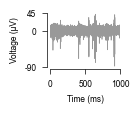

In [ ]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_MV)

# formatting
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_yticks([-90, 0, 45], [-90, 0, 45])
ax.set_ylim([-90, 45])
ax.set_xticks([0, SF_V / 2, SF_V], [0, 500, 1000])
ax.set_xlim([0, SF_V])
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save figure
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2a_compo_vivo_npx.svg")

## Spontaneous biophysical model 

* execution time: 3 min

In [7]:
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

[sudo] password for steeve: 

### Compute

* execution time: 3 min

In [ ]:
%%time

# setup parameters
L5_SITE = 21

# compute figure data
if COMPUTE_FIG_DATA:

    # load raw recording extractors
    Rec = si.load_extractor(RAW_PATH_ns)

    # get metadata
    sfreq = Rec.get_sampling_frequency()
    layers = Rec.get_property("layers")

    # extract first 10 min of the recording extractors 
    Rec = Rec.frame_slice(start_frame=0, end_frame=REC_DURATION_SEC*sfreq)
    print("Recording:", Rec)

    # preprocess voltage traces
    Rec = spre.astype(Rec, "int16")
    Rec = spre.highpass_filter(Rec, freq_min=FREQ_MIN)
    Rec = spre.common_reference(Rec, reference="global", operator="median")

    # select a site and period
    L5_site = np.where(layers == LAYER)[0][L5_SITE]
    one_sec_period = np.arange((ID_PERIOD_SILI - 1) * sfreq, ID_PERIOD_SILI * sfreq, 1) # one second
    traces = Rec.get_traces(channel_ids=[str(L5_site)])

    # plot figure
    fig_data = traces[one_sec_period.astype(int)]

# save figure data
if SAVE_FIG_DATA:
    
    wind_end = int(np.floor(len(traces)/sfreq))
    bkg_noise = noise.measure_trace_noise(traces[one_sec_period.astype(int)], int(sfreq), wind_end)
    np.save(fig_data_paths["fig2b_compo_silico_npx_bkg_noise"], bkg_noise)    
    np.save(fig_data_paths["fig2b_compo_silico_npx"], fig_data)

# load figure data
elif LOAD_FIG_DATA:
    bkg_noise = np.load(fig_data_paths["fig2b_compo_silico_npx_bkg_noise"])    
    fig_data = np.load(join(proj_path, fig_data_paths["fig2b_compo_silico_npx"]))
    print("loaded figure data")
    print("nb of 1-sec windows:", len(bkg_noise))
    print("Background noise level (min MAD over windows):", min(bkg_noise))

Recording: FrameSliceRecording: 384 channels - 40.0kHz - 1 segments - 24,000,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 34.33 GiB
CPU times: user 2min 55s, sys: 52.8 s, total: 3min 48s
Wall time: 3min 54s


### plot

(-130.0, 60.0)

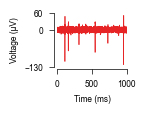

In [ ]:
# setup parameters
YMAX = 60
YMIN = -130
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_MS)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
plt.xticks([0, SF_S / 2, SF_S])
ax.set_xticklabels([0, 500, 1000])
ax.set_xlim([0, SF_S])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_yticks([YMIN, 0, YMAX])
ax.set_ylim([YMIN, YMAX])

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2b_compo_silico_npx.svg")

## Evoked biophysical model 

* execution time: 3 min

In [16]:
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

[sudo] password for steeve: Sorry, try again.
[sudo] password for steeve: 
sudo: no password was provided
sudo: 1 incorrect password attempt


In [ ]:
%%time

# setup parameters
L5_SITE = 21
STIM_START = 20110000

# compute figure data
if COMPUTE_FIG_DATA:

    # load raw recording extractors
    Rec = si.load_extractor(RAW_PATH_e)

    # get metadata
    sfreq = Rec.get_sampling_frequency()
    layers = Rec.get_property("layers")

    # extract first 10 min of the recording extractors 
    Rec = Rec.frame_slice(start_frame=STIM_START, end_frame=STIM_START + REC_DURATION_SEC*sfreq)
    print("Recording:", Rec)

    # preprocess voltage traces
    Rec = spre.astype(Rec, "int16")
    Rec = spre.highpass_filter(Rec, freq_min=FREQ_MIN)
    Rec = spre.common_reference(Rec, reference="global", operator="median")

    # select a site and period
    L5_site = np.where(layers == LAYER)[0][L5_SITE]
    one_sec_period = np.arange(0, sfreq, 1)
    traces = Rec.get_traces(channel_ids=[str(L5_site)])

    # plot figure
    fig_data = traces[one_sec_period.astype(int)]

# save figure data
if SAVE_FIG_DATA:
    
    wind_end = int(np.floor(len(traces)/sfreq))
    bkg_noise = noise.measure_trace_noise(traces[one_sec_period.astype(int)], sfreq, wind_end)
    np.save(fig_data_paths["fig2c_compo_evoked_npx_bkg_noise"], bkg_noise)    
    np.save(fig_data_paths["fig2c_compo_evoked_npx"], fig_data)

# load figure data
elif LOAD_FIG_DATA:
    
    bkg_noise = np.load(fig_data_paths["fig2c_compo_evoked_npx_bkg_noise"])    
    fig_data = np.load(join(proj_path, fig_data_paths["fig2c_compo_evoked_npx"]))
    print("loaded figure data")
    print("nb of 1-sec windows:", len(bkg_noise))
    print("Background noise level (min MAD over windows):", min(bkg_noise))

Recording: FrameSliceRecording: 384 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 17.17 GiB
CPU times: user 1min 27s, sys: 14.3 s, total: 1min 41s
Wall time: 1min 44s


### plot

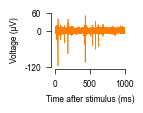

In [ ]:
# plot
YMAX = 60
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_E)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time after stimulus (ms)")
ax.set_yticks([-120, 0, YMAX], [-120, 0, YMAX])
ax.set_ylim([-120, YMAX])
ax.set_xticks([0, SF_E / 2, SF_E], [0, 500, 1000])
ax.set_xlim([0, SF_E])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2c_compo_evoked_npx.svg")

## Synthetic model (Buccino)

In [ ]:
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

In [ ]:
%%time

# setup parameters
ID_PERIOD_B = 43

# compute figure data
if COMPUTE_FIG_DATA:

    # load raw recording extractors
    Rec = si.load_extractor(RAW_PATH_b)

    # get metadata
    sfreq = Rec.get_sampling_frequency()
    layers = Rec.get_property("layers")

    # extract first 10 min of the recording extractors 
    Rec = Rec.frame_slice(start_frame=0, end_frame=REC_DURATION_SEC*sfreq)
    print("Recording:", Rec)

    # preprocess voltage traces
    Rec = spre.astype(Rec, "int16")
    Rec = spre.highpass_filter(Rec, freq_min=FREQ_MIN)
    Rec = spre.common_reference(Rec, reference="global", operator="median")

    # select a site and period
    one_sec_period = np.arange((ID_PERIOD_B - 1) * sfreq, ID_PERIOD_B * sfreq, 1)
    traces = Rec.get_traces(channel_ids=[SITE_B])

    # plot figure
    fig_data = traces[one_sec_period.astype(int)]

# save figure data
if SAVE_FIG_DATA:
    
    wind_end = int(np.floor(len(traces)/sfreq))
    bkg_noise = noise.measure_trace_noise(traces[one_sec_period.astype(int)], int(sfreq), wind_end)
    np.save(fig_data_paths["fig2d_compo_synth_npx_bkg_noise"], bkg_noise)    
    np.save(fig_data_paths["fig2d_compo_synth_npx"], fig_data)

# load figure data
elif LOAD_FIG_DATA:
    
    bkg_noise = np.load(fig_data_paths["fig2d_compo_synth_npx_bkg_noise"])    
    fig_data = np.load(join(proj_path, fig_data_paths["fig2d_compo_synth_npx"]))
    print("loaded figure data")
    print("nb of 1-sec windows:", len(bkg_noise))
    print("Background noise level (min MAD over windows):", min(bkg_noise))

Recording: FrameSliceRecording: 384 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 27.47 GiB
CPU times: user 2min 49s, sys: 41.1 s, total: 3min 31s
Wall time: 3min 40s


### plot

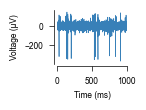

In [ ]:
# plot
YMAX = 60
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_B)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, SF_B / 2, SF_B], [0, 500, 1000])
ax.set_xlim([0, SF_B])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2d_compo_synth_npx.svg")

## Denser probe

In [ ]:
# clear RAM
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

[sudo] password for steeve: 

### Compute

In [13]:
%%time

# setup parameters
ID_PERIOD_SILI = 10
L5_SITE = 10
REC_DURATION_SEC = 600
LAYER = "L5"

# compute figure data
if COMPUTE_FIG_DATA:

    # load raw recording extractors
    Rec = si.load_extractor(RAW_PATH_d2)

    # set gain to uV (0.195 described in https://doi.org/10.1038/s41597-021-00970-3)
    # Rec.set_channel_gains(GAIN_TO_UV)
    print("gain:", Rec.get_channel_gains())

    # get metadata
    sfreq = Rec.get_sampling_frequency()
    layers = Rec.get_property("layers")
    site = np.where(layers == LAYER)[0][L5_SITE]

    # extract first 10 min of the recording extractors 
    Rec = Rec.frame_slice(start_frame=0, end_frame=REC_DURATION_SEC*sfreq)
    print("Recording:", Rec)

    # preprocess voltage traces
    Rec = spre.astype(Rec, "int16")
    Rec = spre.highpass_filter(Rec, freq_min=FREQ_MIN)
    Rec = spre.common_reference(Rec, reference="global", operator="median")

    # select a site and period
    one_sec_period = np.arange((ID_PERIOD_SILI - 1) * sfreq, ID_PERIOD_SILI * sfreq, 1)
    traces = Rec.get_traces(channel_ids=[str(site)])
    traces = traces * GAIN_TO_UV

    # plot figure
    fig_data = traces[one_sec_period.astype(int)]

# save figure data
if SAVE_FIG_DATA:
    
    wind_end = int(np.floor(len(traces)/sfreq))
    bkg_noise = noise.measure_trace_noise(traces[one_sec_period.astype(int)], int(sfreq), wind_end)
    np.save(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"], bkg_noise)    
    np.save(fig_data_paths["fig2d_compo_silico_horv"], fig_data)

# load figure data
elif LOAD_FIG_DATA:
    
    bkg_noise = np.load(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"])    
    fig_data = np.load(join(proj_path, fig_data_paths["fig2d_compo_silico_horv"]))
    print("loaded figure data")
    print("nb of 1-sec windows:", len(bkg_noise))
    print("Background noise level (min MAD over windows):", min(bkg_noise))

gain: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Recording: FrameSliceRecording: 128 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 5.72 GiB
CPU times: user 33.6 s, sys: 3.92 s, total: 37.5 s
Wall time: 37.5 s


### Plot

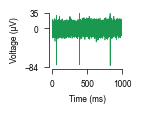

In [15]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax.plot(fig_data, color=COLOR_HS)

# formatting
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, sfreq / 2, sfreq], [0, 500, 1000])
ax.set_xlim([0, sfreq])
ax.set_yticks([-84, 0, 35])
ax.set_ylim([-84, 35])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# # save figure
# if SAVE_FIG:
#     plt.savefig("figures/0_validation/1_components/fig2d_compo_silico_horv.svg")

## Horvath

### Compute

In [ ]:
%%time 

# setup parameters
LAYER = "L5"
L5_SITE = 79 
SAMPLE_START = 15868440
REC_DURATION_SEC = 900 

if COMPUTE_FIG_DATA:
    
    # load recording
    Recording = si.load_extractor(RAW_PATH_h2)

    # set gain to uV (0.195 described in https://doi.org/10.1038/s41597-021-00970-3)
    Recording.set_channel_gains(GAIN_TO_UV)

    # get shorter dration
    Recording = Recording.frame_slice(0, int(REC_DURATION_SEC * Recording.get_sampling_frequency()))

    # preprocess
    Recording = spre.highpass_filter(Recording, freq_min=FREQ_MIN)
    Recording = spre.common_reference(Recording, reference='global', operator='median')

    # get site id
    layers = Recording.get_property("layers")
    site = np.where(layers == LAYER)[0][L5_SITE]

    # extract traces
    traces = Recording.get_traces(channel_ids=[str(site)], return_scaled=True)

    # extract a one-second period
    one_sec_period = np.arange(SAMPLE_START, SAMPLE_START + Recording.get_sampling_frequency(), 1).astype(int)

    # extract site trace within period
    fig_data = traces[one_sec_period, :]

# save figure data
if SAVE_FIG_DATA:
    
    wind_end = int(np.floor(len(traces)/sfreq))
    bkg_noise = noise.measure_trace_noise(traces[one_sec_period.astype(int)], int(sfreq), wind_end)
    np.save(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"], bkg_noise)    
    np.save(fig_data_paths["fig2d_compo_silico_horv"], fig_data)

# load figure data
elif LOAD_FIG_DATA:
    
    bkg_noise = np.load(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"])
    fig_data = np.load(join(proj_path, fig_data_paths["fig2d_compo_silico_horv"]))
    print("loaded figure data")
    print("nb of 1-sec windows:", len(bkg_noise))
    print("Background noise level (min MAD over windows):", min(bkg_noise))

CPU times: user 49.8 s, sys: 5.74 s, total: 55.5 s
Wall time: 55.5 s


### plot

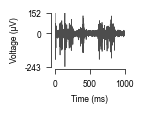

In [ ]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax.plot(fig_data, color=COLOR_HV)

# formatting
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, SF_dense / 2, SF_dense], [0, 500, 1000])
ax.set_xlim([0, SF_dense])
ax.set_yticks([-243, 0, 152], [-243, 0, 152])
ax.set_ylim([-243, 152])
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2e_compo_vivo_horv.svg")